In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install arviz

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 4.1MB 58.9MB/s 
     |████████████████████████████████| 317kB 49.4MB/s 


In [0]:
%matplotlib inline
import numpy as np
import scipy.stats as sps
import scipy.special as spe
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt

# Ensayo de toxicidad

_Este ejemplo reproduce el ejemplo de la sección 3.7 de BDA3 (Bayesian Data Analysis)_

Se exponen varios grupos de animales a diferentes dosis de un químico tóxico y se quiere analizar cómo la respuesta en términos de (no) supervivencia depende de la dosis.

Léanse los datos del archivo de texto `data/bioassay.txt`

In [4]:
data = pd.read_csv('/content/drive/My Drive/CursoMachine/Modelado/data/bioassay.txt', skip_blank_lines=False, header=8)
data.head()

,dose,n,y
0,-0.86,5,0
1,-0.30,5,1
2,-0.05,5,3
3,0.73,5,5


Podemos entender los datos como 4 observaciones de la forma $(x_i, n_i, y_i)$, $i \in [1, 4]$.
Ahora, grafiquemos el número de muertes contra la dosis:

Text(0.5, 0, 'Dose (log g/ml)')

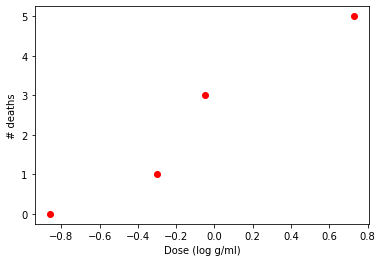

In [5]:
plt.plot(data['dose'], data['y'], 'ro')
plt.ylabel('# deaths')
plt.xlabel('Dose (log g/ml)')

Parece que a medida que la dosis $x_i$ se incrementa, el número de muertes $y_i$ incrementa.

# Posibles modelos

Buscamos modelar las observaciones.  Varias opciones son posibles:

## Various ensayos de Bernoulli

Podemos asumir que cada observación $i \in [1, 4]$ es el resultado de un ensayo de Bernoulli, cada uno con su probabilidad de éxito (en éste caso muerte) $q_i$:
\begin{equation*}
y_i \sim \operatorname{Binomial}(n_i, q_i).
\end{equation*}
Ésta suposición no es muy útil porque no me dice cómo las probabilidades de éxito individuales $q_i$ dependen de la dosis.  Aún así nos vamos moviendo en la dirección correcta: Podemos asumir que $y_i \sim \operatorname{Binomial}(n_i, q_i)$ _y_ que $q_i$ depende de alguna manera de $x_i$.

## Modelo lineal

Un modelo sencillo para la dependencia entre $q_i$ y $x_i$ es el modelo lineal
\begin{equation*}
q_i = \alpha + \beta x_i
\end{equation*}
Desafortunadamente éste modelo no es útil porque $x_i \in \mathbb{R}$ y por lo tanto $q_i \in \mathbb{R}$, i.e., éste modelo devuelve valores de probabilidad posiblemente negativos para ciertos valores de $\alpha$, $\beta$ y $x_i$.

## Modelo logístico

Algo que podemos hacer es pasar el modelo lineal por una función _sigmoidea_ $f \colon \mathbb{R} \to (0, 1)$ (o $(-1, 1)$, dependiendo de la convención), i.e., una función monotónicamente creciente (en forma de "s") que asigna un valor entre $(0, 1)$ a cada uno de los reales.  Un ejemplo común de sigmoide es la función _logit inverso_ (o _logística_ o _expit_) $\operatorname{logit}^{-1}(\cdot)$

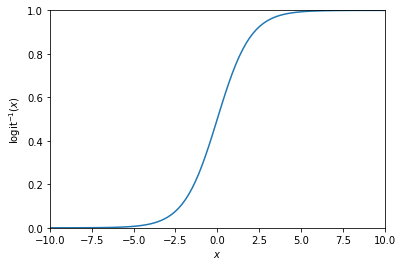

In [6]:
x = np.linspace(-10, 10, 100)
plt.plot(x, spe.expit(x))
plt.ylim(0, 1), plt.xlim(-10, 10)
plt.ylabel(r'$\operatorname{logit}^{-1}(x)$'), plt.xlabel(r'$x$');

En otras palabras, podemos asumir que
\begin{equation*}
q_i = \operatorname{logit}^{-1} \left (\alpha + \beta x_i \right ), \quad y_i \sim \operatorname{Binomial}(n_i, q_i).
\end{equation*}
Éste sería nuestro modelo de verosimilitud $p(y \mid \theta)$, con parámetros $\theta = \{ \alpha, \beta \}$.

Hay varias sigmoideas que podemos utilizar para nuestra verosimilitud, pero el logit tiene una interpretación intuitiva.  El $\operatorname{logit}(q)$ es
\begin{equation*}
\operatorname{logit}(q) = \log \left ( \frac{q}{1 - q} \right ),
\end{equation*}
i.e., $\operatorname{logit}(q)$ es el logaritmo de la proporción de la probabilida de éxito a fracaso. En otras palabras, nuestro modelo es que la log-cuota depende linealmente de la dosis.

## Distribución anterior

Debemos formular una distribución anterior para los parámetros $\theta = \{ \alpha, \beta \}$.  En principio $\alpha$ puede tomar cualquier valor, positivo o negativo, y $\beta$ puede tomar cualquier valor positivo, así que en ausencia de información _a priori_ evidente podemos "dejar que las observaciones hablen por sí mismas" y formular una distribución anterior _no informativa_.

Un valor de $\beta$ negativo indica que la probabilidad de muerte _se reduce_ cuando se aumenta la dosis, lo cual no es consistente con las observaciones.

La distribución anterior
\begin{equation*}
p(\theta) = p(\alpha, \beta) \propto 1
\end{equation*}
establece que todos los valores de $\alpha$ y $\beta$ son "igualmente probables", con énfasis en las comillas: Dado que $\theta \in \mathbb{R}^2$, la integral $\int p(\theta) \, \mathrm{d} \theta$ va a diverger, y por lo tanto $p(\theta)$ no representa una distribución propia (he ahí el nombre _impropia_).

El uso de distribuciones anteriores impropias puede (pero no siempre) resultar en distribuciones posteriores propias e útiles.  En éste caso vamos a utilizar la distribución anterior impropia.

## Otras variables aleatorias

Además de los observables y de los parámetros, también podemos estar interesados en otras variables aleatorias asociadas con el modelo y sus parámetros.  En éste caso una cantidad de interés es la dosis correspondiente a una probabilidad de supervivencia del 50%, conocida como LD50 (_Dosis letal media_).  Para el modelo logístico en consideración,
\begin{equation*}
\operatorname{logit}(0.5) = \log \frac{0.5}{0.5} = \log 1 = 0 = \alpha + \beta \, \mathrm{LD50}
\end{equation*}
Por lo tanto, $\mathrm{LD50} = -\alpha / \beta$

In [0]:
x = data['dose']
x = 0.5 * (x - np.mean(x)) / np.std(x)

## Modelo probabilístico

In [0]:
model = pm.Model()
with model:
    alpha = pm.Flat('alpha')
    beta  = pm.Flat('beta')
    theta = pm.math.invlogit(alpha + beta * data['dose'])
    y     = pm.Binomial('y', p=theta, n=data['n'], observed=data['y'])
    LD50  = pm.Deterministic('LD50', -alpha/beta)

## Inferencia via NUTS

Ahora generamos varias cadenas de muestras de la distribución posterior, cada una de $2000$ muestras, utilizando NUTS:

In [9]:
with model:
    trace = pm.sample(2000, tune=1000, target_accept=0.98, random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
100%|██████████| 3000/3000 [00:04<00:00, 671.27it/s]
The number of effective samples is smaller than 25% for some parameters.


Vale la pena discutir algunos de los argumentos de la función de muestreo:
1. `tune` corresponde al número de muestras que se van a generar al principio y que se utilizan para ajustar a NUTS
2. `target_accept` indica la proporción de muestras aceptadas

NUTS, como todos los algorithmos de MCMC, no es a prueba de balas.  Una vez se han calculado las cadenas, hay qué preguntarse si las cadenas están muestreando la distribución posterior.  Para evaluar esa pregunta hace falta diagnosticar las cadenas:

In [10]:
pm.summary(trace)

/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.331053,1.074332,0.033734,-0.547012,3.549715,860.376771,1.003305
beta,11.663500,5.609186,0.191506,2.306663,22.378534,705.511282,1.003702
LD50,-0.109911,0.093058,0.002173,-0.291693,0.076864,1548.336067,1.000014


Ésta tabla de resumen muestra para cada parámetro:
- La media muestral (`mean`) 
- La desviación estándar muestral (`sd`)
- El error estándar del estimador de la media (`mc_error`)
- El HDI del 95% de la distribución posterior, o HPD (`hpd_2.5` y `hpd_97.5`)
- El número efectivo de muestras (`n_eff`)
- El estadístico de Gelman-Rubin $\hat{R}$ (`Rhat`)

Vale la pena discutir el significado de éstos diagnósticos:
1. El error estándar del estimador de la media aproxima la desviación estándar del error que se puede esperar en el estimador de la media.  Si `mc_error` es pequeño relativo a la media `mean`, podemos decir que las cadenas aproximan la media adecuadamente
2. Dado que MCMC en general no genera muestras independientes, el número "efectivo" de muestras es menor al número generado, lo cual no es en general un problema a menos que sea _mucho_ menor.  En ese caso hay qué pensar en reformular el problem
3. El estadístico $\hat{R}$ cuantifica qué tan diferentes son las cadenas unas a otras.  Si $\hat{R}$ es cercano a uno, se puede decir que las cadenas son similares y por tanto están generando muestras de la distribución anterior.  Si $\hat{R} > 1.1$ las cadenas no han convergido

Adicionalmente, se pueden visualizar las cadenas y la distribución de sus muestras:

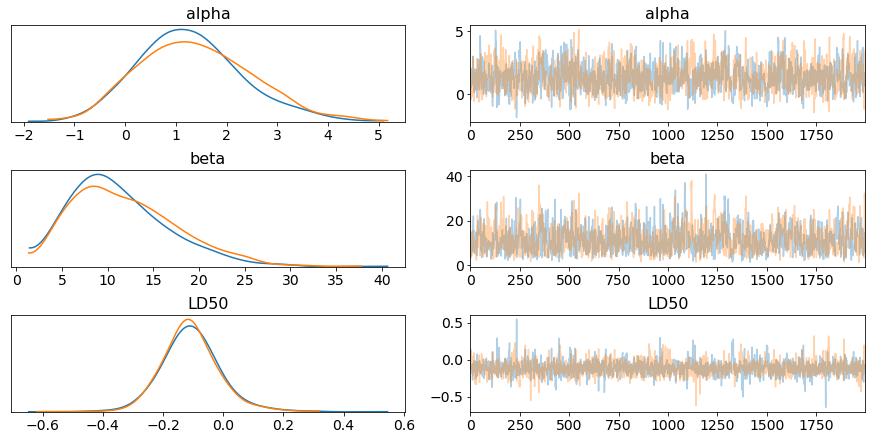

In [11]:
pm.traceplot(trace);

También se pueden visualizar la distribución de las muestras de todas las cadenas:

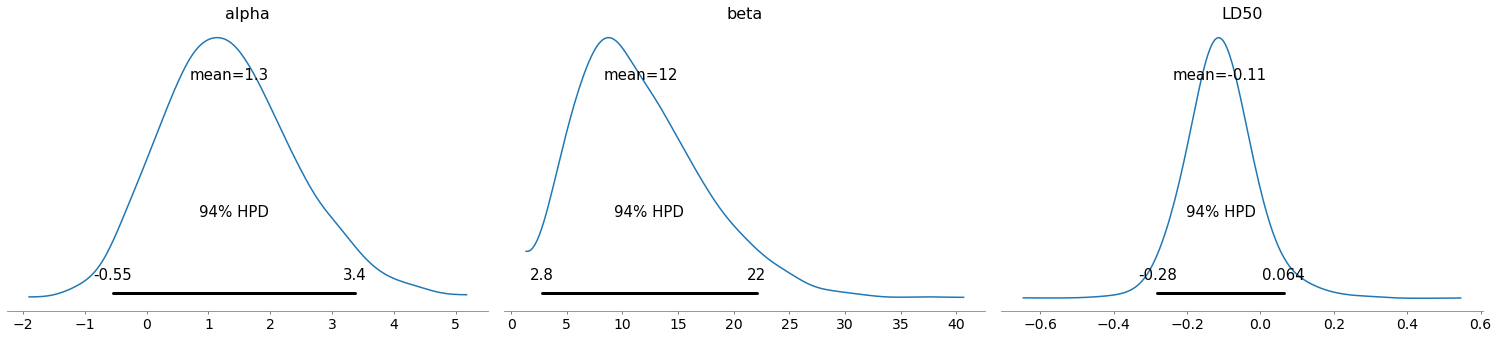

In [12]:
pm.plot_posterior(trace);

Interesantemente, no son muchas (o ninguna) las muestras de $\beta$ negativas:

In [13]:
(trace['beta'] < 0).sum()

0

Finalmente, podemos visualizar la distribución conjunta de los parámetros.  Primero, podemos visualizar un subconjunto de muestras de la posterior utilizando un diagrama de dispersión:

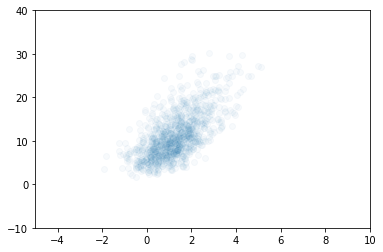

In [14]:
ns=1000
plt.scatter(trace.alpha[:ns], trace.beta[:ns], alpha=0.03)
plt.xlim([-5, 10]);
plt.ylim([-10, 40]);

Segundo, podemos utilizar las muestras de la posterior para aproximar el diagrama de contornos de la distribución posterior.  Para ésto debemos aproximar la posterior a partir de sus muestras utilizando _estimación de densidad de núcle/kernel_ (KDE):

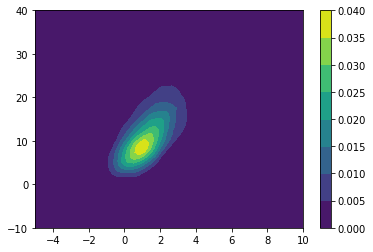

In [15]:
ag, bg = np.mgrid[-5:10:50j, -10:40:50j]
positions = np.vstack([ag.ravel(), bg.ravel()])
kernel = sps.gaussian_kde([trace.alpha, trace.beta])
pdf    = np.reshape(kernel(positions).T, ag.shape)
plt.contourf(ag, bg, pdf)
plt.colorbar()